In [29]:
library(jsonlite)     # flexible, robust, high performance tools for working with JSON in R
library(dplyr)        # A fast, consistent tool for working with data frame like objects
library(stringi)      # Character String Processing Facilities
library(ggplot2)      # An Implementation of the Grammar of Graphics
library(downloader)   # Download Files over HTTP and HTTPS
library(lubridate)    # To work with date-times

#install.packages("downloader")

In [30]:
for(i in 1:11){
    url=paste0("https://download.open.fda.gov/drug/label/drug-label-000",i,"-of-0011.json.zip")
    download(url,dest="json.zip")
    unzip ("json.zip")
}

# https://download.open.fda.gov/drug/label/drug-label-0001-of-0011.json.zip"

Warning message in download.file(url, method = method, ...):
“cannot open URL 'https://download.open.fda.gov/drug/label/drug-label-00010-of-0011.json.zip': HTTP status was '404 Not Found'”


ERROR: Error in download.file(url, method = method, ...): cannot open URL 'https://download.open.fda.gov/drug/label/drug-label-00010-of-0011.json.zip'


In [31]:
# Create character vector of file names

filenames <- list.files(pattern="*.json", full.names=TRUE)

In [32]:
drug1 = fromJSON(filenames[1])

names(drug1)

[1] "meta"    "results"

In [33]:
drug1$meta

$disclaimer
[1] "Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service."

$terms
[1] "https://open.fda.gov/terms/"

$license
[1] "https://open.fda.gov/license/"

$last_updated
[1] "2022-11-24"

$results
$results$skip
[1] 0

$results$limit
[1] 20000

$results$total
[1] 205387

In [34]:
results=drug1$results
class(results)

[1] "data.frame"

In [35]:
glimpse(results)

Rows: 20,000
Columns: 138
$ spl_product_data_elements                                        <list> "Oxy…
$ package_label_principal_display_panel                            <list> "Pri…
$ set_id                                                           <chr> "e65d…
$ id                                                               <chr> "ee16…
$ effective_time                                                   <chr> "2022…
$ version                                                          <chr> "3", …
$ openfda                                                          <df[,21]> <…
$ active_ingredient                                                <list> <NUL…
$ dosage_forms_and_strengths                                       <list> <NUL…
$ purpose                                                          <list> <NUL…
$ indications_and_usage                                            <list> <NUL…
$ warnings                                                         <list> <NUL…
$ pregnancy_or

In [36]:
glimpse(results$openfda)

Rows: 20,000
Columns: 21
$ brand_name                    <list> "Oxygen", "Palladium Metallicum", "SPF …
$ generic_name                  <list> "OXYGEN", "PALLADIUM METALLICUM", "TITA…
$ manufacturer_name             <list> "Resp-I-Care, Inc.", "Hahnemann Laborat…
$ product_ndc                   <list> "58125-0001", <"37662-1992", "37662-199…
$ product_type                  <list> "HUMAN PRESCRIPTION DRUG", "HUMAN OTC D…
$ route                         <list> "RESPIRATORY (INHALATION)", "ORAL", "TO…
$ substance_name                <list> "OXYGEN", "PALLADIUM", <"TITANIUM DIOXI…
$ rxcui                         <list> "312172", <NULL>, <NULL>, <"283316", "2…
$ spl_id                        <list> "ee16c042-8f88-447d-e053-2995a90aae9a",…
$ spl_set_id                    <list> "e65d92c1-71db-4a10-83a4-d2556be7559e",…
$ package_ndc                   <list> <"58125-0001-0", "58125-0001-7", "58125…
$ is_original_packager          <list> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRU…
$ unii         

In [37]:
spl = fromJSON(filenames[1])$results                  # read drug-label-0001-of-0005.json
spl=select(spl,effective_time,boxed_warning)          # select effective_time and boxed_warning

  for(i in 2:length(filenames)){                      # read all the rest
      
      tmp =fromJSON(filenames[i])$results
      
   spl=rbind(spl, select(tmp,effective_time,boxed_warning))  # concatenate all
}

In [38]:
glimpse(spl)

Rows: 180,000
Columns: 2
$ effective_time <chr> "20221122", "20221122", "20210222", "20211013", "202106…
$ boxed_warning  <list> <NULL>, <NULL>, <NULL>, "WARNING: FETAL TOXICITY When …


In [39]:
spl=mutate(spl,effective_time=stri_sub(effective_time,1,8))

In [40]:
spl%>%group_by(nchar(effective_time))%>%summarize(count=n())

nchar(effective_time),count
<int>,<int>
8,180000


In [41]:
# Convert characters to date
spl=mutate(spl,effective_time =ymd(effective_time))

Warning message:
“ 1 failed to parse.”


In [42]:
glimpse(spl)

Rows: 180,000
Columns: 2
$ effective_time <date> 2022-11-22, 2022-11-22, 2021-02-22, 2021-10-13, 2021-0…
$ boxed_warning  <list> <NULL>, <NULL>, <NULL>, "WARNING: FETAL TOXICITY When …


Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


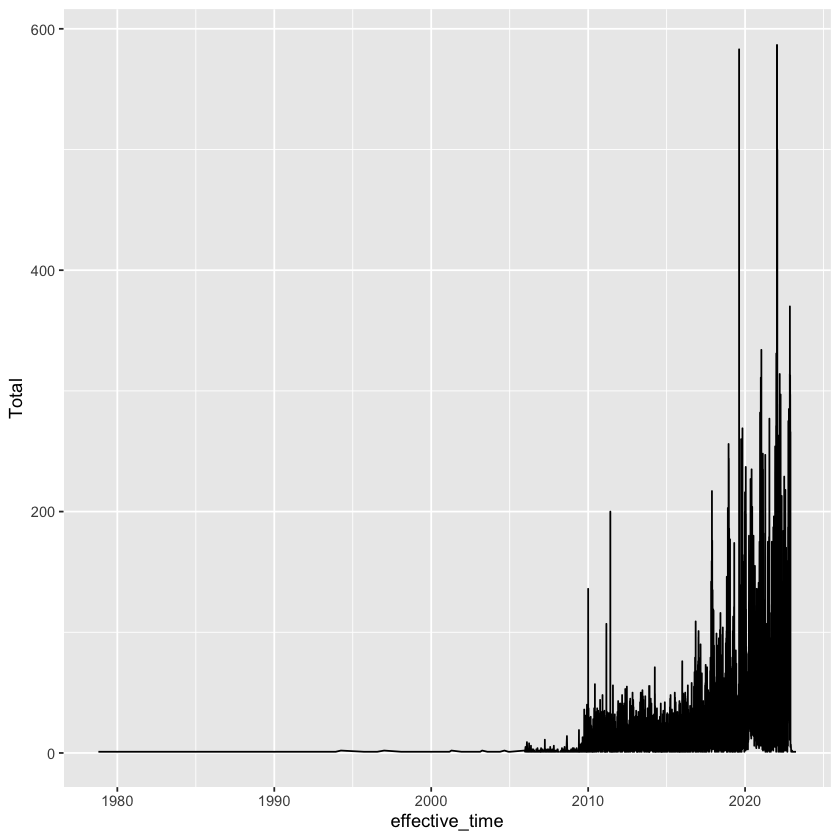

In [43]:
spl%>%group_by(effective_time)%>%summarize(Total=n())%>%
ggplot(aes(x=effective_time,y=Total))+geom_line()

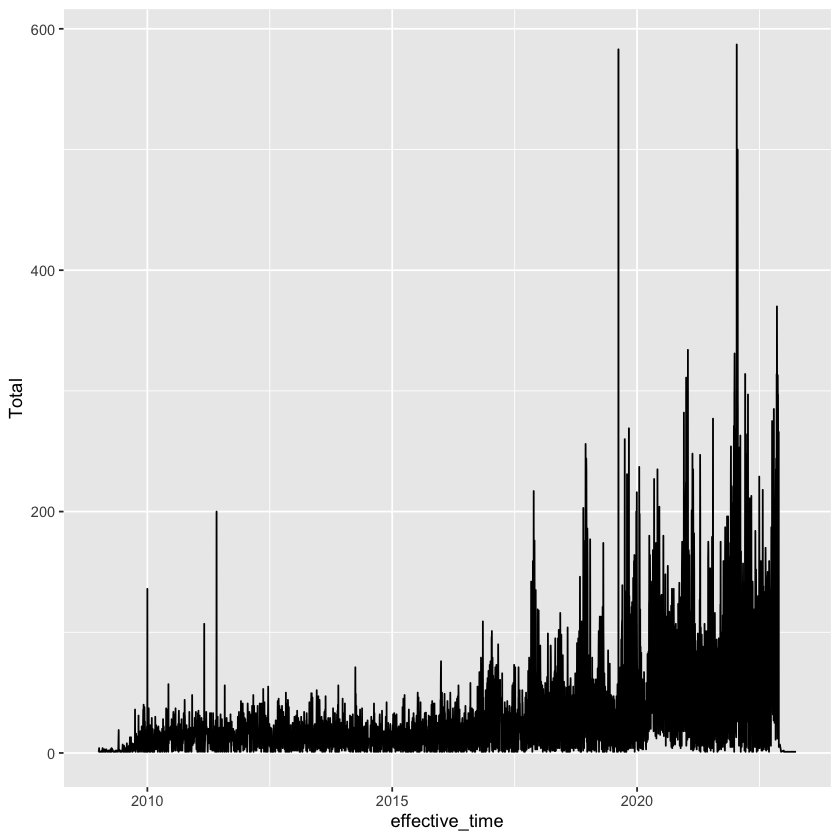

In [44]:
# Exclude submissions prior to 2009
spl%>%filter(effective_time>ymd("20081231"))%>%
              group_by(effective_time)%>%summarize(Total=n())%>%
ggplot(aes(x=effective_time,y=Total))+geom_line()

In [45]:
spl=mutate(spl, year = format(effective_time, "%Y"))

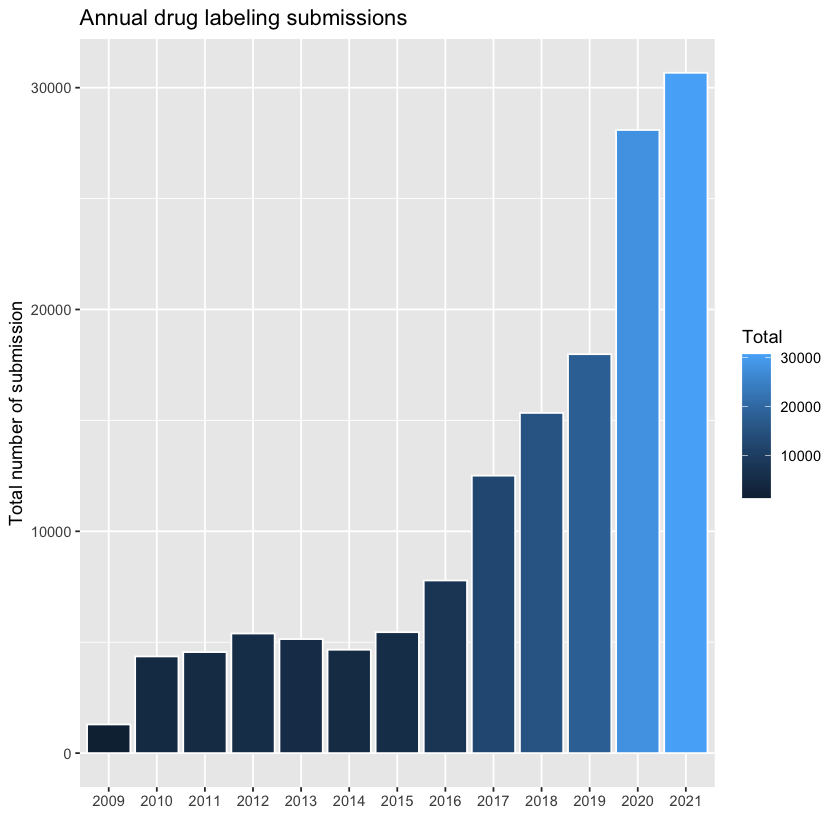

In [47]:
spl%>%
    filter(effective_time>ymd("20081231") & effective_time < ymd("20220101"))%>%
    group_by(year)%>%
    summarize(Total=n())%>%
    ggplot(aes(x=year,y=Total, fill=Total))+geom_bar(stat="identity",color='white')+
    ggtitle('Annual drug labeling submissions')+xlab('')+ylab('Total number of submission')